<a href="https://colab.research.google.com/github/HireTheHero/CausalIntersectionalityDualGradient/blob/main/notebook/intervention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# init

## env setup

In [ ]:
!apt-get install tree

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  tree
0 upgraded, 1 newly installed, 0 to remove and 29 not upgraded.
Need to get 47.9 kB of archives.
After this operation, 116 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tree amd64 2.0.2-1 [47.9 kB]
Fetched 47.9 kB in 0s (103 kB/s)
Selecting previously unselected package tree.
(Reading database ... 126209 files and directories currently installed.)
Preparing to unpack .../tree_2.0.2-1_amd64.deb ...
Unpacking tree (2.0.2-1) ...
Setting up tree (2.0.2-1) ...
Processing triggers for man-db (2.10.2-1) ...


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## modules and variables

In [2]:
import glob
from heapq import heappush, heappop, heappushpop
import math
import os
import re

import dask.dataframe as dd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.optimize import minimize
from scipy.stats import rankdata
from sklearn.metrics import roc_curve, roc_auc_score

In [3]:
# Define the root directory
root_directory = '/content/drive/MyDrive/vilio/export'

# Regular expression to match the expected filenames
filename_pattern = re.compile(r'^(img|txt)_((?:OV|[OUV])\d{1,3})_dev_seen_result_(cross|image|text|all)\.csv$')


# csv collection

## show folder structure

In [ ]:
!tree -d /content/drive/MyDrive/vilio/export

/content/drive/MyDrive/vilio/export
├── additional_figures
├── correct_label
│   ├── O
│   │   ├── attattr
│   │   ├── attention
│   │   ├── gradient
│   │   └── sample_analysis
│   ├── U
│   │   ├── attattr
│   │   ├── attention
│   │   ├── gradient
│   │   └── sample_analysis
│   └── V
│       ├── attattr
│       │   └── text_only
│       ├── attention
│       ├── gradient
│       └── sample_analysis
├── eps
│   ├── O
│   │   ├── midas_cross
│   │   │   └── attattr
│   │   │       ├── image
│   │   │       └── text
│   │   ├── midas_image
│   │   │   └── attattr
│   │   │       ├── image
│   │   │       └── text
│   │   └── midas_text
│   │       └── attattr
│   │           ├── image
│   │           └── text
│   ├── U
│   │   ├── midas_cross
│   │   │   └── attattr
│   │   │       ├── image
│   │   │       └── text
│   │   ├── midas_image
│   │   │   └── attattr
│   │   │       ├── image
│   │   │       └── text
│   │   └── midas_text
│   │       └── attattr
│   │           ├── image

## load to dataframe

In [4]:
# Collect all CSV files under the root directory recursively
pattern = os.path.join(root_directory, '**', '*.csv')
all_csv_files = glob.glob(pattern, recursive=True)

# Filter out files that don't match the expected file name pattern
file_info_list = []
for filepath in all_csv_files:
    filename = os.path.basename(filepath)
    if filename_pattern.match(filename):
        # Extract metadata as before
        path_parts = filepath.split(os.sep)
        if len(path_parts) < 4:
            continue
        model_name = path_parts[-3]
        analysis_type = path_parts[-2]
        match = filename_pattern.match(filename)
        if match:
            # input_type = match.group(1)
            model_subtype = match.group(2)
            interaction_type = match.group(3)
            file_info_list.append({
                'filepath': filepath,
                'model_name': model_name,
                'analysis_type': analysis_type,
                # 'input_type': input_type,
                'model_subtype': model_subtype,
                'interaction_type': interaction_type
            })

print(f"Found {len(file_info_list)} relevant CSV files to process.")

# Read and combine CSV files using Dask DataFrame
ddf_list = []
for info in file_info_list:
    # Read CSV into Dask DataFrame
    df = dd.read_csv(info['filepath'])
    # Add metadata columns
    df = df.assign(
        model_name=info['model_name'],
        analysis_type=info['analysis_type'],
        # input_type=info['input_type'],
        model_subtype=info['model_subtype'],
        interaction_type=info['interaction_type']
    )
    ddf_list.append(df)

# Concatenate all Dask DataFrames
if ddf_list:
    combined_ddf = dd.concat(ddf_list, axis=0, interleave_partitions=True)
    # Compute the result to get a pandas DataFrame
    combined_df = combined_ddf.compute()
    # Save combined DataFrame
    combined_df.to_csv('combined_results.csv', index=False)
    print("Combined DataFrame saved to 'combined_results.csv'.")
else:
    print("No data to combine.")

Found 480 relevant CSV files to process.
Combined DataFrame saved to 'combined_results.csv'.


In [ ]:
# combined_df[combined_df["analysis_type"]=="attattr"].groupby(["model_name", "model_subtype", "mod", "interaction_type"])["id"].nunique()

In [ ]:
# combined_df[(combined_df["model_name"]=="attattr")].head()

### preprocessing

In [5]:
df_scope = combined_df[(combined_df["interaction_type"]=="all")&(combined_df["model_name"]!="attattr")].drop_duplicates().reset_index(drop=True)
df_scope = df_scope.rename(columns={"mod": "input_modality"})
df_scope.head()

,id,input_modality,score,micace,score_pos,score_neg,p_pos,p_neg,model_name,analysis_type,model_subtype,interaction_type
0,1726,txt,-0.000001,0.006276,0.000007,0.000007,0.992601,0.986325,O,attattr,OV50,all
1,2634,txt,-0.000002,0.996531,0.000096,0.000098,0.999385,0.002854,O,attattr,OV50,all
2,2783,txt,-0.0,0.33568,0.000012,0.000012,0.338589,0.002909,O,attattr,OV50,all
3,3519,txt,-0.000002,0.994688,0.000111,0.000112,0.997842,0.003154,O,attattr,OV50,all
4,3567,txt,0.000001,0.878905,0.000053,0.000052,0.889791,0.010886,O,attattr,OV50,all


In [6]:
# Melt the DataFrame to long format
df_long = pd.melt(
    df_scope,
    id_vars=['id', 'model_name', 'model_subtype', 'input_modality'],
    value_vars=['p_pos', 'p_neg'],
    var_name='label',
    value_name='p'
)

# Map the labels to 1 and 0
df_long['label'] = df_long['label'].map({'p_pos': 1, 'p_neg': 0})

# Reorder columns if necessary
df_long = df_long[['id', 'model_name', 'model_subtype', 'input_modality', 'label', 'p']].drop_duplicates().reset_index(drop=True)
df_long.head()

,id,model_name,model_subtype,input_modality,label,p
0,1726,O,OV50,txt,1,0.992601
1,2634,O,OV50,txt,1,0.999385
2,2783,O,OV50,txt,1,0.338589
3,3519,O,OV50,txt,1,0.997842
4,3567,O,OV50,txt,1,0.889791


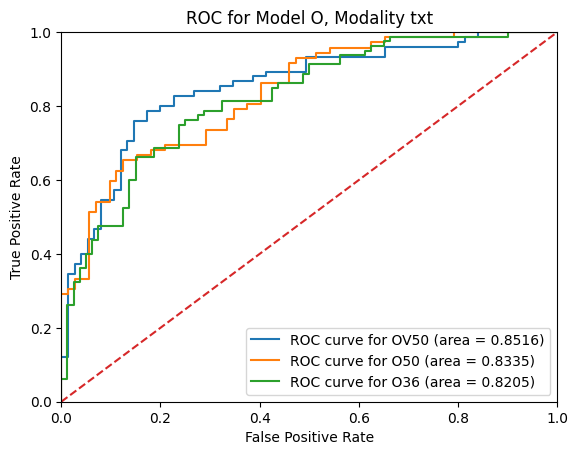

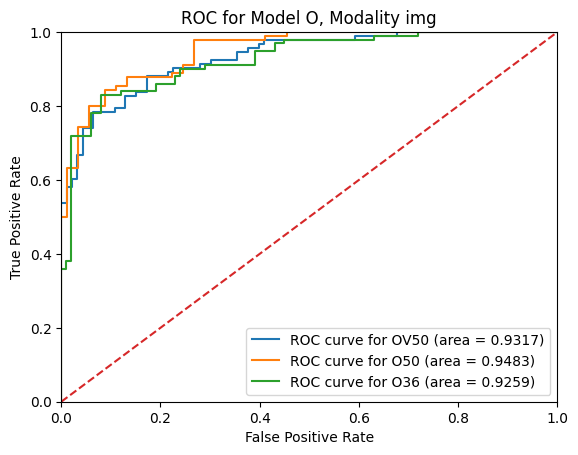

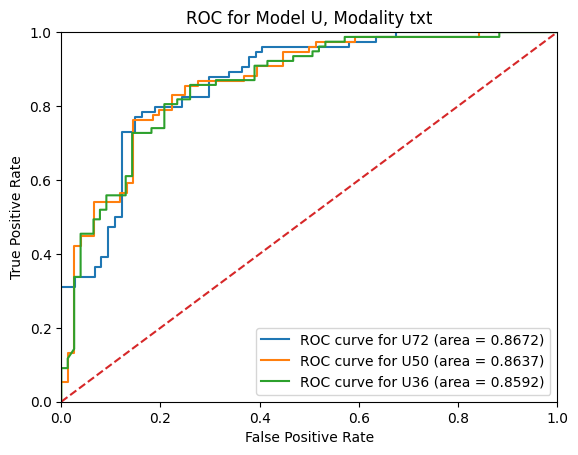

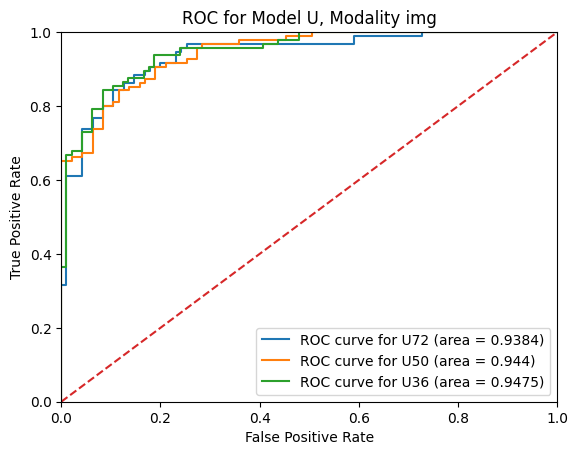

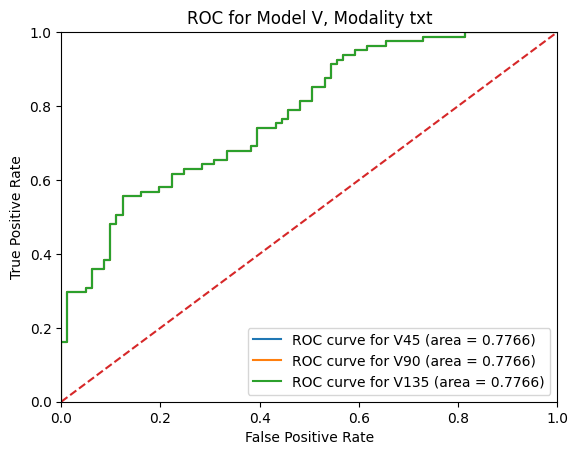

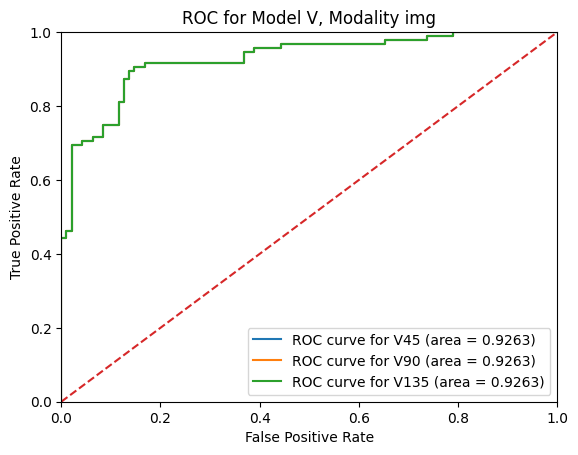

In [ ]:
# # check raw performance
# models = df_long['model_name'].unique()
# for model in models:
#     df_model = df_long[df_long['model_name'] == model].reset_index(drop=True)
#     for modality in ["txt", "img"]:
#         df_model_modality = df_model[df_model['input_modality'] == modality].reset_index(drop=True)
#         for subtype in df_model_modality['model_subtype'].unique():
#             df_model_subtype = df_model_modality[df_model_modality['model_subtype'] == subtype].reset_index(drop=True)

#             y_test = df_model_subtype["label"].values
#             y_scores = df_model_subtype["p"].values
#             ## ROC曲線の描画
#             fpr, tpr, thresholds = roc_curve(y_test, y_scores)
#             plt.plot(fpr, tpr, label=f'ROC curve for {subtype} (area = {round(roc_auc_score(y_test, y_scores), 4)})')
#         plt.plot([0, 1], [0, 1], linestyle='--')
#         plt.xlim([0.0, 1.0])
#         plt.ylim([0.0, 1.0])
#         plt.xlabel('False Positive Rate')
#         plt.ylabel('True Positive Rate')
#         plt.title(f'ROC for Model {model}, Modality {modality}')
#         plt.legend(loc="lower right")
#         plt.show()

# ensemble

## check implementation

### [inference notebook](https://www.kaggle.com/code/muennighoff/hm-inference3)

```
# O
!cd ../vilio; bash ./bash/inference/O/hm_OSA.sh
...
# U
!cd ../vilio; bash ./bash/inference/U/hm_USA.sh
# V
!cd ../vilio; bash ./bash/inference/V/hm_VSA.sh
...
# Combine
!cd ../vilio; bash bash/hm_ens.sh
```
### bash/inference/{O|U|V}/hm_{[O](https://github.com/Muennighoff/vilio/blob/50eb7cc9c901795c394070f7705fc0c5a7667bd2/bash/inference/O/hm_OSA.sh)|[U](https://github.com/Muennighoff/vilio/blob/50eb7cc9c901795c394070f7705fc0c5a7667bd2/bash/inference/U/hm_USA.sh)|[V](https://github.com/Muennighoff/vilio/blob/50eb7cc9c901795c394070f7705fc0c5a7667bd2/bash/inference/V/hm_VSA.sh)}SA.sh
```
# O
...
# Simple Average O-Model outputs
python utils/ens.py --enspath ./data/ --enstype sa --exp O365050

# U
...
# Simple Average
python utils/ens.py --enspath ./data/ --enstype sa --exp U365072

# V
...
# Simple Average
python utils/ens.py --enspath ./data/ --enstype sa --exp VLMDB
```
### [utils/ens.py](https://github.com/Muennighoff/vilio/blob/50eb7cc9c901795c394070f7705fc0c5a7667bd2/utils/ens.py)
```
def simple_average(targets, example, weights=None, power=1, normalize=False):
    """
    targets: df with target values as columns
    example: output df example (e.g. including ID - make sure to adjust iloc below if target is not at 1)
    weights: per submission weights; default is equal weighting
    power: optional for power averaging
    normalize: Whether to normalize targets btw 0 & 1
    """
    if weights is None:
        weights = len(targets.columns) * [1.0 / len(targets.columns)]
    else:
        weights = weights / np.sum(weights)

    preds = example.copy()
    preds.iloc[:,1] = np.zeros(len(preds))

    if normalize:
        targets = (targets - targets.min())/(targets.max()-targets.min())
    for i in range(len(targets.columns)):
        preds.iloc[:,1] = np.add(preds.iloc[:, 1], weights[i] * (targets.iloc[:, i].astype(float)**power))
    
    return preds
```
### [bash/hm_ens.sh](https://github.com/Muennighoff/vilio/blob/50eb7cc9c901795c394070f7705fc0c5a7667bd2/bash/hm_ens.sh)
```
...
# Simple Average
python utils/ens.py --enspath ./data/ --enstype loop --exp ENS
```

### xx
```
def main(path, gt_path="./data/"):
    """
    Loops through Averaging, Power Averaging, Rank Averaging, Optimization to find the best ensemble.

    path: String to directory with csvs of all models
    For each model there should be three csvs: dev, test, test_unseen

    gt_path: Path to folder with ground truth for dev
    """
    # Ground truth
    input_df = pd.read_json(os.path.join(gt_path, 'dev_seen.jsonl'), lines=True)

    # Make sure the lists will be ordered, i.e. test[0] is the same model as devs[0]
    ...

    loop, last_score, delta = 0, 0, 0.1

    while (delta > 0.0001):

        # Individual Roc Aucs
        ...

        for i, column in enumerate(dev_probas):
            score = roc_auc_score(input_df.label, dev_probas.iloc[:, i])
            print(column, score)
        ...

        if loop > 0:
            while len(dev) > 5:
                lowest_score = 1
                drop = 0
                for i, column in enumerate(dev_probas):
                    score = roc_auc_score(input_df.label, dev_probas.iloc[:, i])
                    if score < lowest_score:
                        lowest_score = score
                        col = column
                        drop = i

                column_numbers = [x for x in range(dev_probas.shape[1])]  # list of columns' integer indices
                column_numbers.remove(drop)
                dev_probas = dev_probas.iloc[:, column_numbers]
                ...
    
                if i < len(dev_or):
                    dev_or.pop(drop)
                    test_or.pop(drop)
                    test_unseen_or.pop(drop)
                if i < len(dev):
                    dev.pop(drop)
                    test.pop(drop)
                    test_unseen.pop(drop)
    
                print("Dropped:", col)
                
        # Spearman Correlations:
        print("Spearman Corrs:")
        dev_corr = dev_probas.corr(method='spearman')
        ...

        ### SIMPLE AVERAGE ###
        dev_SA = simple_average(dev_probas, dev[0], power=1, normalize=True)
        ...

        ### POWER AVERAGE ###
        dev_PA = simple_average(dev_probas, dev[0], power=2, normalize=True)
        ...

        ### RANK AVERAGE ###
        dev_RA = rank_average(dev)
        ...

        ### SIMPLEX ###
        weights_dev = Simplex(dev_probas, input_df.label)

        dev_SX = simple_average(dev_probas, dev[0], weights_dev)
        ...

        # Prepare Next Round
        dev = dev_or + [dev_SA, dev_PA, dev_RA, dev_SX]
        test = test_or + [test_SA, test_PA, test_RA, test_SX]
        test_unseen = test_unseen_or + [test_unseen_SA, test_unseen_PA, test_unseen_RA, test_unseen_SX]
                
        dev_probas = pd.concat([df.proba for df in dev], axis=1)
        ...

        # Calculate Delta & increment loop
        delta = abs(roc_auc_score(input_df.label, dev_SX.proba) - last_score)
        last_score = roc_auc_score(input_df.label, dev_SX.proba)

        loop += 1

        # I found the loop to not add any value after 2 rounds.
        if loop == 2:
            break
    
    print("Currently at {} after {} loops.".format(last_score, loop))

    # Get accuracy thresholds & optimize (This does not add value to the roc auc, but just to also have an acc score)
    ...

    # Set path instd of /k/w ; Remove all csv data / load the exact same 3 files again as put out
    # As Simplex at some point simply weighs the highest of all - lets take sx as the final prediction after x loops
    dev_SX.to_csv(os.path.join(path, "FIN_dev_seen_" + args.exp + "_" + str(loop) + ".csv"), index=False)
    ...
```

## apply to miATE/MIDAS

### function

In [7]:
class _Simplex:
	def __init__(self, pointIndices, testCoords, contentFractions, objectiveScore, opportunityCost, contentFraction, difference):
		self.pointIndices = pointIndices
		self.testCoords = testCoords
		self.contentFractions = contentFractions
		self.contentFraction = contentFraction
		self.__objectiveScore = objectiveScore
		self.__opportunityCost = opportunityCost
		self.update(difference)

	def update(self, difference):
		self.acquisitionValue = -(self.__objectiveScore + (self.__opportunityCost * difference))
		self.difference = difference

	def __eq__(self, other):
		return self.acquisitionValue == other.acquisitionValue

	def __lt__(self, other):
		return self.acquisitionValue < other.acquisitionValue

class SimpleTuner:
	def __init__(self, cornerPoints, objectiveFunction, exploration_preference=0.15, capacity_increment=1000):
		self.capacity_increment = capacity_increment
		self.__cornerPoints = cornerPoints
		self.__numberOfVertices = len(cornerPoints)
		self.queue = []
		self.capacity = self.__numberOfVertices + self.capacity_increment
		self.testPoints = np.empty((self.capacity, self.__numberOfVertices))
		self.objective = objectiveFunction
		self.iterations = 0
		self.maxValue = None
		self.minValue = None
		self.bestCoords = []
		self.opportunityCostFactor = exploration_preference #/ self.__numberOfVertices


	def optimize(self, maxSteps=10):
		for step in range(maxSteps):
			#print(self.maxValue, self.iterations, self.bestCoords)
			if len(self.queue) > 0:
				targetSimplex = self.__getNextSimplex()
				newPointIndex = self.__testCoords(targetSimplex.testCoords)
				for i in range(0, self.__numberOfVertices):
					tempIndex = targetSimplex.pointIndices[i]
					targetSimplex.pointIndices[i] = newPointIndex
					newContentFraction = targetSimplex.contentFraction * targetSimplex.contentFractions[i]
					newSimplex = self.__makeSimplex(targetSimplex.pointIndices, newContentFraction)
					heappush(self.queue, newSimplex)
					targetSimplex.pointIndices[i] = tempIndex
			else:
				testPoint = self.__cornerPoints[self.iterations]
				testPoint.append(0)
				testPoint = np.array(testPoint, dtype=np.float64)
				self.__testCoords(testPoint)
				if self.iterations == (self.__numberOfVertices - 1):
					initialSimplex = self.__makeSimplex(np.arange(self.__numberOfVertices, dtype=np.intp), 1)
					heappush(self.queue, initialSimplex)
			self.iterations += 1

	def get_best(self):
		return (self.maxValue, self.bestCoords[0:-1])

	def __getNextSimplex(self):
		targetSimplex = heappop(self.queue)
		currentDifference = self.maxValue - self.minValue
		while currentDifference > targetSimplex.difference:
			targetSimplex.update(currentDifference)
			# if greater than because heapq is in ascending order
			if targetSimplex.acquisitionValue > self.queue[0].acquisitionValue:
				targetSimplex = heappushpop(self.queue, targetSimplex)
		return targetSimplex

	def __testCoords(self, testCoords):
		objectiveValue = self.objective(testCoords[0:-1])
		if self.maxValue == None or objectiveValue > self.maxValue:
			self.maxValue = objectiveValue
			self.bestCoords = testCoords
			if self.minValue == None: self.minValue = objectiveValue
		elif objectiveValue < self.minValue:
			self.minValue = objectiveValue
		testCoords[-1] = objectiveValue
		if self.capacity == self.iterations:
			self.capacity += self.capacity_increment
			self.testPoints.resize((self.capacity, self.__numberOfVertices))
		newPointIndex = self.iterations
		self.testPoints[newPointIndex] = testCoords
		return newPointIndex


	def __makeSimplex(self, pointIndices, contentFraction):
		vertexMatrix = self.testPoints[pointIndices]
		coordMatrix = vertexMatrix[:, 0:-1]
		barycenterLocation = np.sum(vertexMatrix, axis=0) / self.__numberOfVertices

		differences = coordMatrix - barycenterLocation[0:-1]
		distances = np.sqrt(np.sum(differences * differences, axis=1))
		totalDistance = np.sum(distances)
		barycentricTestCoords = distances / totalDistance

		euclideanTestCoords = vertexMatrix.T.dot(barycentricTestCoords)

		vertexValues = vertexMatrix[:,-1]

		testpointDifferences = coordMatrix - euclideanTestCoords[0:-1]
		testPointDistances = np.sqrt(np.sum(testpointDifferences * testpointDifferences, axis=1))



		inverseDistances = 1 / testPointDistances
		inverseSum = np.sum(inverseDistances)
		interpolatedValue = inverseDistances.dot(vertexValues) / inverseSum


		currentDifference = self.maxValue - self.minValue
		opportunityCost = self.opportunityCostFactor * math.log(contentFraction, self.__numberOfVertices)

		return _Simplex(pointIndices.copy(), euclideanTestCoords, barycentricTestCoords, interpolatedValue, opportunityCost, contentFraction, currentDifference)

	def plot(self):
		if self.__numberOfVertices != 3: raise RuntimeError('Plotting only supported in 2D')
		matrix = self.testPoints[0:self.iterations, :]

		x = matrix[:,0].flat
		y = matrix[:,1].flat
		z = matrix[:,2].flat

		coords = []
		acquisitions = []

		for triangle in self.queue:
			coords.append(triangle.pointIndices)
			acquisitions.append(-1 * triangle.acquisitionValue)


		plt.figure()
		plt.tricontourf(x, y, coords, z)
		plt.triplot(x, y, coords, color='white', lw=0.5)
		plt.colorbar()


		plt.figure()
		plt.tripcolor(x, y, coords, acquisitions)
		plt.triplot(x, y, coords, color='white', lw=0.5)
		plt.colorbar()

		plt.show()

In [8]:
def simple_average(df, prediction_cols=None, weights=None, power=1):
    """
    Calculates the simple (or weighted) power mean of probability columns in the DataFrame.
    Adds a new column 'proba' to the DataFrame with the computed mean.
    Parameters:
        df (pd.DataFrame): Input DataFrame containing probability columns.
        prediction_cols (list): List of column names to use for averaging.
        weights (list or array-like, optional): Weights for weighted mean.
    Must be the same length as the number of probability columns.
        power (float, optional): The exponent specifying the type of power mean to compute.
            Default is 1 (arithmetic mean).
    Returns:
        pd.DataFrame: DataFrame with an additional column 'proba' containing the computed mean.
    """
    if prediction_cols is None:
        raise ValueError("prediction_cols must be provided")
    prob_cols = prediction_cols
    if weights is not None:
        if len(weights) != len(prob_cols):
            raise ValueError("Length of weights must match number of probability columns.")
        if power == 0:
            # Compute weighted geometric mean
            weighted_logs = df[prob_cols].apply(np.log).mul(weights)
            numerator = weighted_logs.sum(axis=1)
            denominator = sum(weights)
            df['proba'] = np.exp(numerator / denominator)
        else:
            # Compute weighted power mean
            numerator = df[prob_cols].pow(power).mul(weights).sum(axis=1)
            denominator = sum(weights)
            df['proba'] = (numerator / denominator).pow(1 / power)
    else:
        if power == 0:
            # Compute geometric mean
            logs = df[prob_cols].apply(np.log)
            numerator = logs.sum(axis=1)
            denominator = len(prob_cols)
            df['proba'] = np.exp(numerator / denominator)
        else:
            # Compute simple (unweighted) power mean
            numerator = df[prob_cols].pow(power).sum(axis=1)
            denominator = len(prob_cols)
            df['proba'] = (numerator / denominator).pow(1 / power)
    return df

def rank_average(df, prediction_cols=None):
    """
    Calculates the rank average of probability columns in the DataFrame.
    Adds a new column 'proba' to the DataFrame with the computed rank average.
    Parameters:
        df (pd.DataFrame): Input DataFrame containing probability columns.
        prediction_cols (list): List of column names to use for averaging.
    Returns:
        pd.DataFrame: DataFrame with an additional column 'proba' containing the rank averaged predictions.
    """
    if prediction_cols is None:
        raise ValueError("prediction_cols must be provided")
    # Rank each probability column
    ranked_probs = df[prediction_cols].rank(method='average')
    # Calculate the average rank
    avg_rank = ranked_probs.mean(axis=1)
    # Normalize the average rank to get probabilities between 0 and 1
    df['proba'] = avg_rank / (len(df) + 1)
    return df

# pick-one version
def Simplex(devs, label, prediction_cols=None, df_list=False, exploration=0.01, scale=1):
    """
    Optimizes the weights for model predictions to maximize ROC AUC score.
    Parameters:
        devs (pd.DataFrame or list of DataFrames): Model predictions.
        label (array-like): Ground truth labels.
        prediction_cols (list): List of column names to use for optimization.
        df_list (bool): If True, devs is a list of DataFrames containing 'proba' column.
        exploration (float): Exploration preference for the optimizer.
        scale (int): Scale of the weights.
    Returns:
        list: Optimized weights.
    """
    predictions = []
    if df_list:
        # If devs is a list of DataFrames with 'proba' column
        for df in devs:
            predictions.append(df['proba'])
    else:
        if prediction_cols is None:
            raise ValueError("prediction_cols must be provided")
        # If devs is a DataFrame with model prediction columns
        for col in prediction_cols:
            predictions.append(devs[col])
    print("Optimizing {} inputs.".format(len(predictions)))
    def roc_auc(weights):
        '''Objective function to maximize ROC AUC score given weights'''
        final_prediction = 0
        for weight, prediction in zip(weights, predictions):
                final_prediction += weight * prediction
        return roc_auc_score(label, final_prediction)
    # Define the search area and optimizer parameters
    zero_vtx = np.zeros((1, len(predictions)), dtype=int)
    optimization_domain_vertices = np.identity(len(predictions), dtype=int) * scale
    optimization_domain_vertices = np.concatenate((zero_vtx, optimization_domain_vertices), axis=0).tolist()
    number_of_iterations = 3000
    # Initialize SimpleTuner for optimization
    tuner = SimpleTuner(optimization_domain_vertices, roc_auc, exploration_preference=exploration)
    tuner.optimize(number_of_iterations)
    best_objective_value, best_weights = tuner.get_best()
    print('Optimized ROC AUC =', best_objective_value)  # Same as roc_auc(best_weights)
    print('Optimized Weights =', best_weights)
    return best_weights

# combination version
def SimplexComb(devs, label, prediction_cols=None, df_list=False):
    """
    Optimizes the weights for model predictions to maximize ROC AUC score using continuous weights.
    Parameters:
        devs (pd.DataFrame or list of DataFrames): Model predictions.
        label (array-like): Ground truth labels.
        prediction_cols (list): List of column names to use for optimization.
        df_list (bool): If True, devs is a list of DataFrames containing 'proba' column.
    Returns:
        list: Optimized weights.
    """
    predictions = []
    if df_list:
        for df in devs:
            predictions.append(pd.to_numeric(df['proba'], errors='raise').values)
    else:
        if prediction_cols is None:
            raise ValueError("prediction_cols must be provided")
        for col in prediction_cols:
            predictions.append(pd.to_numeric(devs[col], errors='raise').values)
    print("Optimizing {} inputs.".format(len(predictions)))
    def neg_roc_auc(weights):
        '''Objective function to minimize negative ROC AUC score given weights'''
        final_prediction = np.zeros_like(predictions[0], dtype=float)
        for weight, prediction in zip(weights, predictions):
            final_prediction += weight * prediction
        return -roc_auc_score(label, final_prediction)
    # Initial guess: equal weights
    x0 = np.ones(len(predictions)) / len(predictions)
    # Constraints: weights sum to 1
    constraints = {'type': 'eq', 'fun': lambda w: np.sum(w) - 1}
    # Bounds: weights between 0 and 1
    bounds = [(0, 1) for _ in range(len(predictions))]
    # Optimize
    result = minimize(neg_roc_auc, x0, method='SLSQP', bounds=bounds, constraints=constraints)
    best_weights = result.x
    best_score = -result.fun
    print('Optimized ROC AUC =', best_score)
    print('Optimized Weights =', best_weights)
    return best_weights

In [9]:
def optimize(input_df, simplex_mode="pick_one"):
    # Initialize loop variables
    loop, last_score, delta = 0, 0, 0.1
    # Identify model prediction columns by excluding 'id' and 'label'
    columns_to_exclude = ['label']
    if 'id' in input_df.columns:
        columns_to_exclude.append('id')
    prediction_cols = [col for col in input_df.columns if col not in columns_to_exclude]
    # Keep track of original model columns
    original_model_cols = prediction_cols.copy()
    # Separate predictions and labels
    dev_probas = input_df[prediction_cols].copy()
    dev_probas = dev_probas.apply(pd.to_numeric, errors='raise')  # Ensure numeric
    labels = pd.to_numeric(input_df['label'].copy())  # Ensure numeric
    # Keep a copy of the original predictions
    dev_or = [dev_probas.copy()]
    # Start ensemble optimization loop
    while delta > 0.0001:
        print(f"\nLoop {loop + 1}:")
        # Individual ROC AUC scores
        print("Individual ROC AUC Scores:")
        for column in dev_probas.columns:
            score = roc_auc_score(labels, dev_probas[column])
            print(f"{column}: {score}")
        # If it's not the first loop, drop the lowest scoring models to keep top 5
        if loop > 0 and len(original_model_cols) > 5:
            while len(original_model_cols) > 5:
                # Find the column with the lowest ROC AUC score among original model columns
                scores = {column: roc_auc_score(labels, dev_probas[column]) for column in original_model_cols}
                drop_col = min(scores, key=scores.get)
                # Drop the column with the lowest score
                dev_probas.drop(columns=drop_col, inplace=True)
                dev_or[0].drop(columns=drop_col, inplace=True)
                original_model_cols.remove(drop_col)
                print(f"Dropped: {drop_col}")
        # Spearman Correlations:
        print("\nSpearman Correlations:")
        dev_corr = dev_probas.corr(method='spearman')
        print(dev_corr)
        # Prepare DataFrames for ensemble methods
        # Make copies to avoid modifying original DataFrames
        dev_SA = dev_probas.copy()
        dev_PA = dev_probas.copy()
        dev_RA = dev_probas.copy()
        dev_SX = dev_probas.copy()
        # Use the current list of original model columns
        current_prediction_cols = original_model_cols.copy()
        ### SIMPLE AVERAGE ###
        dev_SA = simple_average(dev_SA, prediction_cols=current_prediction_cols, power=1)
        ### POWER AVERAGE ###
        dev_PA = simple_average(dev_PA, prediction_cols=current_prediction_cols, power=2)
        ### RANK AVERAGE ###
        dev_RA = rank_average(dev_RA, prediction_cols=current_prediction_cols)
        ### SIMPLEX ###
        # Get optimized weights using Simplex
        if simplex_mode=="pick_one":
            weights_dev = Simplex(dev_probas, labels, prediction_cols=current_prediction_cols)
        else:
            weights_dev = SimplexComb(dev_probas, labels, prediction_cols=current_prediction_cols)
        # Apply the optimized weights using the simple_average function
        dev_SX = simple_average(dev_SX, prediction_cols=current_prediction_cols, weights=weights_dev)
        # Prepare for the next round by combining ensembles
        # Rename 'proba' columns to identify ensemble methods
        dev_list = []
        dev_list += dev_or  # Original models
        dev_SA_renamed = dev_SA[['proba']].rename(columns={'proba': 'SA'})
        dev_PA_renamed = dev_PA[['proba']].rename(columns={'proba': 'PA'})
        dev_RA_renamed = dev_RA[['proba']].rename(columns={'proba': 'RA'})
        dev_SX_renamed = dev_SX[['proba']].rename(columns={'proba': 'SX'})
        dev_list.append(dev_SA_renamed)
        dev_list.append(dev_PA_renamed)
        dev_list.append(dev_RA_renamed)
        dev_list.append(dev_SX_renamed)
        # Concatenate all models and ensemble predictions
        dev_probas = pd.concat(dev_list, axis=1)
        # Update prediction_cols to include ensemble methods for the next iteration
        prediction_cols = dev_probas.columns.tolist()
        # Calculate delta using the ROC AUC of the simplex ensemble
        current_score = roc_auc_score(labels, dev_SX['proba'])
        delta = abs(current_score - last_score)
        print(f"\nSimplex Ensemble ROC AUC: {current_score}")
        print(f"Delta: {delta}")
        last_score = current_score
        loop += 1
        # Limit the loop to 2 iterations as per the original code
        if loop == 2:
            break
    print("\nFinal Optimized Ensemble ROC AUC Score:")
    print(f"{last_score}")
    # Return the final ensemble predictions
    return dev_SX

In [10]:
# def optimize(input_df):
#     """
#     Loops through Averaging, Power Averaging, Rank Averaging, and Optimization to find the best ensemble.
#     Parameters:
#         input_df (pd.DataFrame): DataFrame containing model predictions and ground truth labels.
#             The DataFrame should have all model prediction columns, a 'label' column for ground truths,
#             and may contain an 'id' column for unique identifiers.
#     Returns:
#         pd.Series: Final ensemble predictions.
#     """
#     # Initialize loop variables
#     loop, last_score, delta = 0, 0, 0.1
#     # Identify model prediction columns by excluding 'id' and 'label'
#     columns_to_exclude = ['label']
#     if 'id' in input_df.columns:
#         columns_to_exclude.append('id')
#     prediction_cols = [col for col in input_df.columns if col not in columns_to_exclude]
#     # Separate predictions and labels
#     dev_probas = input_df[prediction_cols]
#     labels = input_df['label']
#     # Keep a copy of the original predictions
#     dev_or = [input_df[prediction_cols].copy()]
#     # Start ensemble optimization loop
#     while delta > 0.0001:
#         print(f"\nLoop {loop + 1}:")
#         # Individual ROC AUC scores
#         print("Individual ROC AUC Scores:")
#         for i, column in enumerate(dev_probas.columns):
#             score = roc_auc_score(labels, dev_probas[column])
#             print(f"{column}: {score}")
#         # If it's not the first loop, drop the lowest scoring models to keep top 5
#         if loop > 0:
#             while len(dev_probas.columns) > 5:
#                 # Find the column with the lowest ROC AUC score
#                 scores = {column: roc_auc_score(labels, dev_probas[column]) for column in dev_probas.columns}
#                 drop_col = min(scores, key=scores.get)
#                 # Drop the column with the lowest score
#                 dev_probas.drop(columns=drop_col, inplace=True)
#                 dev_or[0].drop(columns=drop_col, inplace=True)
#                 prediction_cols.remove(drop_col)
#                 print(f"Dropped: {drop_col}")
#         # Spearman Correlations:
#         print("\nSpearman Correlations:")
#         dev_corr = dev_probas.corr(method='spearman')
#         print(dev_corr)
#         # Prepare DataFrames for ensemble methods
#         # Make copies to avoid modifying original DataFrames
#         dev_SA = dev_probas.copy()
#         dev_PA = dev_probas.copy()
#         dev_RA = dev_probas.copy()
#         dev_SX = dev_probas.copy()
#         ### SIMPLE AVERAGE ###
#         dev_SA = simple_average(dev_SA, prediction_cols=dev_probas.columns.tolist(), power=1)
#         ### POWER AVERAGE ###
#         dev_PA = simple_average(dev_PA, prediction_cols=dev_probas.columns.tolist(), power=2)
#         ### RANK AVERAGE ###
#         dev_RA = rank_average(dev_RA, prediction_cols=dev_probas.columns.tolist())
#         ### SIMPLEX ###
#         # Get optimized weights using Simplex
#         weights_dev = Simplex(dev_probas, labels, prediction_cols=dev_probas.columns.tolist())
#         # Apply the optimized weights using the simple_average function
#         dev_SX = simple_average(dev_SX, prediction_cols=dev_probas.columns.tolist(), weights=weights_dev)

#         # Prepare for the next round by combining ensembles
#         # Rename 'proba' columns to identify ensemble methods
#         dev_list = []
#         dev_list += dev_or  # Original models
#         dev_SA_renamed = dev_SA[['proba']].rename(columns={'proba': 'SA'})
#         dev_PA_renamed = dev_PA[['proba']].rename(columns={'proba': 'PA'})
#         dev_RA_renamed = dev_RA[['proba']].rename(columns={'proba': 'RA'})
#         dev_SX_renamed = dev_SX[['proba']].rename(columns={'proba': 'SX'})
#         dev_list.append(dev_SA_renamed)
#         dev_list.append(dev_PA_renamed)
#         dev_list.append(dev_RA_renamed)
#         dev_list.append(dev_SX_renamed)
#         # Concatenate all models and ensemble predictions
#         dev_probas = pd.concat(dev_list, axis=1)
#         prediction_cols = dev_probas.columns.tolist()
#         # Calculate delta using the ROC AUC of the simplex ensemble
#         current_score = roc_auc_score(labels, dev_SX['proba'])
#         delta = abs(current_score - last_score)
#         print(f"\nSimplex Ensemble ROC AUC: {current_score}")
#         print(f"Delta: {delta}")
#         last_score = current_score
#         loop += 1
#         # Limit the loop to 2 iterations as per the original code
#         if loop == 2:
#             break
#     print("\nFinal Optimized Ensemble ROC AUC Score:")
#     print(f"{last_score}")
#     # Return the final ensemble predictions
#     return dev_SX['proba']

In [11]:
# def optimize(input_df):
#     """
#     Loops through Averaging, Power Averaging, Rank Averaging, and Optimization to find the best ensemble.
#     Parameters:
#         input_df (pd.DataFrame): DataFrame containing model predictions and ground truth labels.
#             The DataFrame should have all model prediction columns, a 'label' column for ground truths,
#             and may contain an 'id' column for unique identifiers.
#     Returns:
#         pd.Series: Final ensemble predictions.
#     """
#     # Initialize loop variables
#     loop, last_score, delta = 0, 0, 0.1
#     # Identify model prediction columns by excluding 'id' and 'label'
#     columns_to_exclude = ['label']
#     if 'id' in input_df.columns:
#         columns_to_exclude.append('id')
#     prediction_cols = [col for col in input_df.columns if col not in columns_to_exclude]
#     # Keep track of original model columns
#     original_model_cols = prediction_cols.copy()
#     # Separate predictions and labels
#     dev_probas = input_df[prediction_cols].copy()
#     labels = input_df['label'].copy()
#     # Keep a copy of the original predictions
#     dev_or = [input_df[prediction_cols].copy()]
#     # Start ensemble optimization loop
#     while delta > 0.0001:
#         print(f"\nLoop {loop + 1}:")
#         # Individual ROC AUC scores
#         print("Individual ROC AUC Scores:")
#         for column in dev_probas.columns:
#             score = roc_auc_score(labels, dev_probas[column])
#             print(f"{column}: {score}")
#         # If it's not the first loop, drop the lowest scoring models to keep top 5
#         if loop > 0:
#             while len(original_model_cols) > 5:
#                 # Find the column with the lowest ROC AUC score among original model columns
#                 scores = {column: roc_auc_score(labels, dev_probas[column]) for column in original_model_cols}
#                 drop_col = min(scores, key=scores.get)
#                 # Drop the column with the lowest score
#                 dev_probas.drop(columns=drop_col, inplace=True)
#                 dev_or[0].drop(columns=drop_col, inplace=True)
#                 original_model_cols.remove(drop_col)
#                 print(f"Dropped: {drop_col}")
#         # Spearman Correlations:
#         print("\nSpearman Correlations:")
#         dev_corr = dev_probas.corr(method='spearman')
#         print(dev_corr)
#         # Prepare DataFrames for ensemble methods
#         # Make copies to avoid modifying original DataFrames
#         dev_SA = dev_probas.copy()
#         dev_PA = dev_probas.copy()
#         dev_RA = dev_probas.copy()
#         dev_SX = dev_probas.copy()
#         # Use the current list of original model columns
#         current_prediction_cols = original_model_cols.copy()
#         ### SIMPLE AVERAGE ###
#         dev_SA = simple_average(dev_SA, prediction_cols=current_prediction_cols, power=1)
#         ### POWER AVERAGE ###
#         dev_PA = simple_average(dev_PA, prediction_cols=current_prediction_cols, power=2)
#         ### RANK AVERAGE ###
#         dev_RA = rank_average(dev_RA, prediction_cols=current_prediction_cols)
#         ### SIMPLEX ###
#         # Get optimized weights using Simplex
#         weights_dev = Simplex(dev_probas, labels, prediction_cols=current_prediction_cols)
#         # Apply the optimized weights using the simple_average function
#         dev_SX = simple_average(dev_SX, prediction_cols=current_prediction_cols, weights=weights_dev)
#         # Prepare for the next round by combining ensembles
#         # Rename 'proba' columns to identify ensemble methods
#         dev_list = []
#         dev_list += dev_or  # Original models
#         dev_SA_renamed = dev_SA[['proba']].rename(columns={'proba': 'SA'})
#         dev_PA_renamed = dev_PA[['proba']].rename(columns={'proba': 'PA'})
#         dev_RA_renamed = dev_RA[['proba']].rename(columns={'proba': 'RA'})
#         dev_SX_renamed = dev_SX[['proba']].rename(columns={'proba': 'SX'})
#         dev_list.append(dev_SA_renamed)
#         dev_list.append(dev_PA_renamed)
#         dev_list.append(dev_RA_renamed)
#         dev_list.append(dev_SX_renamed)
#         # Concatenate all models and ensemble predictions
#         dev_probas = pd.concat(dev_list, axis=1)
#         # Update prediction_cols to include ensemble methods for the next iteration
#         prediction_cols = dev_probas.columns.tolist()
#         # Calculate delta using the ROC AUC of the simplex ensemble
#         current_score = roc_auc_score(labels, dev_SX['proba'])
#         delta = abs(current_score - last_score)
#         print(f"\nSimplex Ensemble ROC AUC: {current_score}")
#         print(f"Delta: {delta}")
#         last_score = current_score
#         loop += 1
#         # Limit the loop to 2 iterations as per the original code
#         if loop == 2:
#             break
#     print("\nFinal Optimized Ensemble ROC AUC Score:")
#     print(f"{last_score}")
#     # Return the final ensemble predictions
#     return dev_SX

In [12]:
def convert_df(df):
    """
    Converts a long-format DataFrame into a dictionary of wide-format DataFrames
    grouped by 'model_name'. Each DataFrame in the dictionary is pivoted on 'model_subtype',
    with probabilities 'p' as the values.

    Parameters:
        df (pd.DataFrame): Input DataFrame with columns ['id', 'model_name', 'model_subtype', 'label', 'p']

    Returns:
        dict: Dictionary where keys are 'model_name' and values are pivoted DataFrames
    """
    # Initialize an empty dictionary to hold the DataFrames per model_name
    model_dict = {}

    # Get unique model_names
    model_names = df['model_name'].unique()

    for name in model_names:
        # Filter the DataFrame for the current model_name
        df_model = df[df['model_name'] == name]

        # Pivot the DataFrame to wide format
        df_pivot = df_model.pivot_table(
            index=['id', 'label'],
            columns='model_subtype',
            values='p'
        ).reset_index()

        # Flatten the column index resulting from pivot (if necessary)
        df_pivot.columns.name = None  # Remove the 'model_subtype' name

        # Rename the probability columns to include 'p_' prefix
        # p_columns = [f'p_{col}' for col in df_pivot.columns if col not in ['id', 'label']]
        p_dict = {col: f'p_{col}' for col in df_pivot.columns if col not in ['id', 'label']}
        # df_pivot.rename(columns=p_columns, inplace=True)
        # df_pivot.rename(columns={col: f'p_{col}' for col in p_columns}, inplace=True)
        df_pivot.rename(columns=p_dict, inplace=True)

        # Sort columns for consistency
        # print(df_pivot.columns)
        # print(['id', 'label'] + sorted(p_columns, key=lambda x: x))
        # df_pivot = df_pivot[['id', 'label'] + sorted(p_columns, key=lambda x: x)]
        df_pivot = df_pivot[['id', 'label'] + sorted(list(p_dict.values()))]

        # Add the DataFrame to the dictionary
        model_dict[name] = df_pivot.dropna()

    return model_dict

### total ensemble

In [13]:
ens_dict = {}
for modality in df_long["input_modality"].unique():
    print(f"Pipeline for {modality}")
    print("Data conversion")
    df_modality = df_long[df_long["input_modality"] == modality].reset_index(drop=True)
    model_dict = convert_df(df_modality)
    print("Intra-model ensemble")
    # Loop through each model_name and apply the functions
    for model_name, df_model in model_dict.items():
        prediction_cols = df_model.columns[df_model.columns.str.contains("p_")]
        # Apply simple average
        df_model = simple_average(df_model, prediction_cols=prediction_cols, weights=None).drop(prediction_cols, axis=1).rename(columns={"proba": f"p_{model_name}"})
        if model_name==list(model_dict.keys())[0]:
            df_models = df_model.copy()
        else:
            df_models = df_models.merge(df_model, on=["id", "label"], how="inner")
    print("Inter-model ensemble")
    df_models["id"] = df_models["id"].astype(str) + "_" + df_models["label"].astype(str)
    df_result = optimize(df_models)# .drop("p_U", axis=1)[["id", "label", "p_V", "p_O"]]
    ens_dict[modality] = df_result.copy()
    print("=====================")

Pipeline for txt
Data conversion
Intra-model ensemble
Inter-model ensemble

Loop 1:
Individual ROC AUC Scores:
p_O: 0.8865306122448979
p_U: 0.916734693877551
p_V: 0.7959183673469388

Spearman Correlations:
          p_O       p_U       p_V
p_O  1.000000  0.887114  0.796588
p_U  0.887114  1.000000  0.693465
p_V  0.796588  0.693465  1.000000
Optimizing 3 inputs.
Optimized ROC AUC = 0.916734693877551
Optimized Weights = [0. 1. 0.]

Simplex Ensemble ROC AUC: 0.916734693877551
Delta: 0.916734693877551

Loop 2:
Individual ROC AUC Scores:
p_O: 0.8865306122448979
p_U: 0.916734693877551
p_V: 0.7959183673469388
SA: 0.8848979591836734
PA: 0.8824489795918367
RA: 0.896734693877551
SX: 0.916734693877551

Spearman Correlations:
          p_O       p_U       p_V        SA        PA        RA        SX
p_O  1.000000  0.887114  0.796588  0.953425  0.953250  0.964689  0.887114
p_U  0.887114  1.000000  0.693465  0.914968  0.916508  0.926107  1.000000
p_V  0.796588  0.693465  1.000000  0.878366  0.869443  

In [ ]:
# df_txt = df_long[df_long["input_modality"] == "txt"].reset_index(drop=True)
# df_img = df_long[df_long["input_modality"] == "img"].reset_index(drop=True)
# df_txt[df_txt["id"]==1726].sort_values(by=["model_name", "model_subtype"])
# df_txt[df_txt["id"]==2634].sort_values(by=["model_name", "model_subtype"])
# model_dict = convert_df(df_txt)
# model_dict = convert_df(df_img)
# model_dict["O"].head()
# # Loop through each model_name and apply the functions
# for model_name, df_model in model_dict.items():
#     prediction_cols = df_model.columns[df_model.columns.str.contains("p_")]
#     # Apply simple average
#     df_model = simple_average(df_model, prediction_cols=prediction_cols, weights=None).drop(prediction_cols, axis=1).rename(columns={"proba": f"p_{model_name}"})
#     if model_name==list(model_dict.keys())[0]:
#         df_models = df_model.copy()
#     else:
#         df_models = df_models.merge(df_model, on=["id", "label"], how="inner")
# df_models.head()
# df_models["id"] = df_models["id"].astype(str) + "_" + df_models["label"].astype(str)
# df_result = optimize(df_models)# .drop("p_U", axis=1)[["id", "label", "p_V", "p_O"]]
# df_result.head()

In [ ]:
import time
for i in range(1000000):
    time.sleep(1)

KeyboardInterrupt: 

### intra-model ensemble

In [14]:
modalities = df_long["input_modality"].unique()
intra_dict = {md: {} for md in modalities}
for modality in modalities:
    print(f"Pipeline for {modality}")
    print("Data conversion")
    df_modality = df_long[df_long["input_modality"] == modality].reset_index(drop=True)
    model_dict = convert_df(df_modality)
    print("Intra-model ensemble")
    # Loop through each model_name and apply the functions
    for model_name, df_model in model_dict.items():
        print(f"Model {model_name}")
        df_result = optimize(df_model)
        intra_dict[modality][model_name] = df_result.copy()
        print("---------------------")
    print("=====================")

Pipeline for txt
Data conversion
Intra-model ensemble
Model O

Loop 1:
Individual ROC AUC Scores:
p_O36: 0.8407372400756142
p_O50: 0.8369565217391304
p_OV50: 0.8492438563327033

Spearman Correlations:
           p_O36     p_O50    p_OV50
p_O36   1.000000  0.867932  0.914723
p_O50   0.867932  1.000000  0.867423
p_OV50  0.914723  0.867423  1.000000
Optimizing 3 inputs.
Optimized ROC AUC = 0.8586956521739131
Optimized Weights = [0.32000074 0.18247207 0.4780654 ]

Simplex Ensemble ROC AUC: 0.8586956521739131
Delta: 0.8586956521739131

Loop 2:
Individual ROC AUC Scores:
p_O36: 0.8407372400756142
p_O50: 0.8369565217391304
p_OV50: 0.8492438563327033
SA: 0.8563327032136107
PA: 0.857750472589792
RA: 0.8565689981096408
SX: 0.8586956521739131

Spearman Correlations:
           p_O36     p_O50    p_OV50        SA        PA        RA        SX
p_O36   1.000000  0.867932  0.914723  0.962363  0.961346  0.964776  0.964490
p_O50   0.867932  1.000000  0.867423  0.937148  0.929874  0.946242  0.923616
p_O